### How to run Metrcs on DDF or other specified areas

In [1]:
# development code
%load_ext autoreload
%autoreload 2

### Software Setup (repeat each session)

In [2]:
# import common python packages
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys, glob
import pandas as pd
import numpy as np

##### Detect and Set Your SciServer Username
__Note:__ Your usename will be used to store MAF output, so please make sure it is correct.

In [3]:
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
    ' If it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311. If it is incorrect, please mannually reset it.


##### Import the $\texttt{rubin_sim}$ modules needed.

In [54]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metricBundles as mb
import rubin_sim.maf.plots as plots
import rubin_sim.maf.batches as batches
import rubin_sim.utils as rs_utils

# footprint utils
from rubin_sim.scheduler.utils import footprints

# import convenience functions for MAF analysis on SciServer
from opsimUtils import *

# print version
import rubin_sim
rubin_sim.__version__

'0.10.1.dev62+gbb0801e'

In [13]:
# specify path to the opsim database and create database object
dbfile = '/home/idies/workspace/lsst_cadence/fbs2/sim_dbs/baseline_v2.1_10yrs.db'
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)

#### Define a metric to run

In [51]:
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')
constraint = 'filter = "g"'

### 1. Compute Metrics in DDF only
Since fbs v2.1, there are no longer propoal tables in the opsim database; thus, we will swith to using a footprint mask (circular for DDF) to specify the specific region in which we would like to evaluate metrics. 

In [50]:
# show ddf centers
ddfCoord

{'COSMOS': (150.11, 2.14),
 'ELAISS1': (9.487, -44.0),
 'XMM-LSS': (35.707, -4.72),
 'ECDFS': (53.15, -28.08),
 'EDFS_a': (58.9, -49.315),
 'EDFS_b': (63.6, -47.6),
 'EDFS': (61.28, -48.42)}

In [32]:
# function to specify a circular footprint
def _set_circular_region(ra_center, dec_center, radius, nside=64):
        # find the healpixels that cover a circle of radius radius around ra/dec center (deg)
        ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)
        result = np.zeros(len(ra))
        distance = rs_utils._angularSeparation(np.radians(ra_center), np.radians(dec_center),
                                               np.radians(ra), np.radians(dec))
        result[np.where(distance < np.radians(radius))] = 1
        return result

In [34]:
# construct a healpix mask consponding to an input region
ddf_centers = ddfCoord
dd = 'COSMOS'
ddf_radius=1.8
nside = 64
hp_idx = _set_circular_region(ddf_centers[dd][0], ddf_centers[dd][1], ddf_radius, nside=nside)

In [52]:
# ddf slicer based-on the healpix footprint mask
ddfslicer = slicers.HealpixSubsetSlicer(nside, np.where(hp_idx == 1)[0])
# create metric Bundle
ddf_bundle = mb.MetricBundle(metric, ddfslicer, constraint, info_label='DDF only')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying table None with constraint filter = "g" for columns ['rotSkyPos', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 214824 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


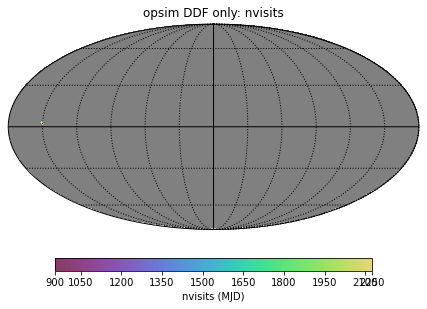

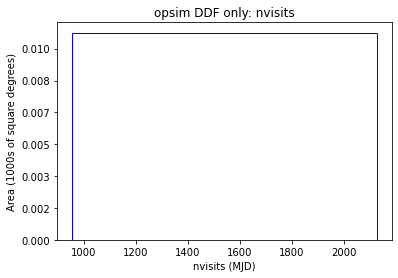

In [53]:
ddf_g = mb.MetricBundleGroup({'0': ddf_bundle}, opsdb, outDir=outDir)
ddf_g.runAll()
ddf_g.plotAll(closefigs=False, savefig=False)

### 2. Compute metrics in the galactic plane

In [58]:
# gp slicer
gp = footprints.galactic_plane_healpixels(nside=nside)
gpslicer = slicers.HealpixSubsetSlicer(nside, np.where(gp==1)[0])

# create metric Bundle
gp_bundle = mb.MetricBundle(metric, gpslicer, constraint, info_label='GP')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying table None with constraint filter = "g" for columns ['rotSkyPos', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 214824 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "g"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.


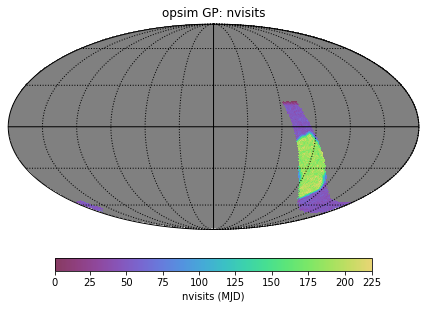

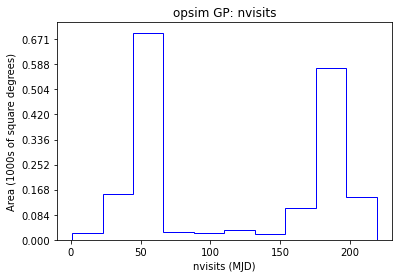

In [59]:
other_g = mb.MetricBundleGroup({'0': gp_bundle}, opsdb, outDir=outDir)
other_g.runAll()
other_g.plotAll(closefigs=False, savefig=False)